## ANALIZA TELEMETRII BOLIDU F1
# Cel - próba określenia jaką strategię przyjmuje kierowca, w jakiej fazie wyścigu jest. Czy naciska czy może oszczędza opony?

# Wstępna charakterystyka, Przygotowanie danych

Pobieramy dane dotyczące pierwszego GP w 2023 roku - Bahrainu. Uzyskujemy Listę wszystkich sesji, Practice 1, Practice 2, Sprint, Race etc.

In [150]:
from urllib.request import urlopen
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sessions_url = f'https://api.openf1.org/v1/sessions?country_name=Bahrain&year=2023'

response = urlopen(sessions_url)
sessions_data = json.loads(response.read().decode('utf-8'))
sessions_data

[{'location': 'Sakhir',
  'country_key': 36,
  'country_code': 'BRN',
  'country_name': 'Bahrain',
  'circuit_key': 63,
  'circuit_short_name': 'Sakhir',
  'session_type': 'Practice',
  'session_name': 'Practice 1',
  'date_start': '2023-02-23T07:00:00+00:00',
  'date_end': '2023-02-23T16:30:00+00:00',
  'gmt_offset': '03:00:00',
  'session_key': 9222,
  'meeting_key': 1140,
  'year': 2023},
 {'location': 'Sakhir',
  'country_key': 36,
  'country_code': 'BRN',
  'country_name': 'Bahrain',
  'circuit_key': 63,
  'circuit_short_name': 'Sakhir',
  'session_type': 'Practice',
  'session_name': 'Practice 2',
  'date_start': '2023-02-24T07:00:00+00:00',
  'date_end': '2023-02-24T16:30:00+00:00',
  'gmt_offset': '03:00:00',
  'session_key': 7763,
  'meeting_key': 1140,
  'year': 2023},
 {'location': 'Sakhir',
  'country_key': 36,
  'country_code': 'BRN',
  'country_name': 'Bahrain',
  'circuit_key': 63,
  'circuit_short_name': 'Sakhir',
  'session_type': 'Practice',
  'session_name': 'Practic

Pobieramy telemetrię bolidu dla wybranego kierowcy, w tym wypadku Maxa Verstappena (numer 1). Funkcja zwraca dane bolidu i czasów okrążeń dotyczące treningu i wyścigu.

In [151]:
driver_number = 1

def get_session_data(session_key):
    
    car_url = f'https://api.openf1.org/v1/car_data?driver_number={driver_number}&session_key={session_key}'
    response = urlopen(car_url)
    car_data = json.loads(response.read().decode('utf-8'))
    
    laps_url = f'https://api.openf1.org/v1/laps?session_key={session_key}&driver_number={driver_number}'
    response = urlopen(laps_url)
    laps_data = json.loads(response.read().decode('utf-8'))
        
    return car_data, laps_data


for session in sessions_data:
    match session["session_name"]:
        case "Qualifying":
            qualifying_car_data, qualifying_laps_data = get_session_data(session["session_key"])
        case "Race":
            race_car_data, race_laps_data = get_session_data(session["session_key"])


Wrzucamy dane do DataFrame, usuwamy zbędne kolumny i parsujemy datę do poprawnego formatu

In [152]:
df_qualifying_car_data = pd.DataFrame(qualifying_car_data)
df_qualifying_car_data = df_qualifying_car_data.iloc[:, 1:-2]

df_qualifying_car_data['date'] = pd.to_datetime(df_qualifying_car_data['date'], format='ISO8601')

df_qualifying_car_data.dtypes

rpm                       int64
speed                     int64
n_gear                    int64
throttle                  int64
brake                     int64
drs                       int64
date        datetime64[ns, UTC]
dtype: object

Z jakiegoś powodu w aktywność drs jest określona w danych na 9 różnych sposobów, w naszej analizie wystarczy nam informacja czy drs jest otwarty, czy też nie, więc tak je normalizujemy

![alt text](image.png)

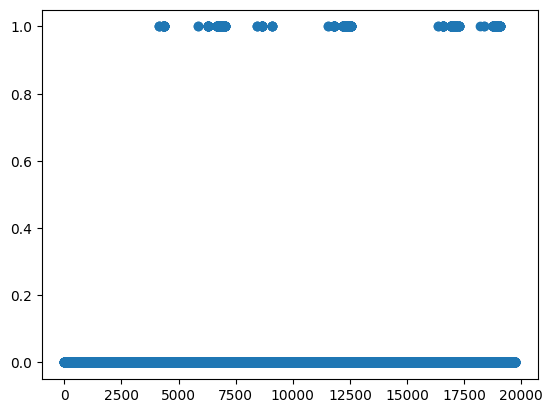

In [153]:
df_qualifying_car_data['drs'] = df_qualifying_car_data['drs'].apply(lambda x: 1 if x in [10, 12, 14] else 0)

plt.scatter(df_qualifying_car_data.index, df_qualifying_car_data['drs'])

Mimo że throttle i brake powinny zawierać się w wartościach 0-100, dochodzą one do 104

In [154]:
df_qualifying_car_data.describe()

,rpm,speed,n_gear,throttle,brake,drs
count,19732.000000,19732.000000,19732.000000,19732.000000,19732.000000,19732.000000
mean,3402.376799,55.707531,1.352727,32.164099,25.424488,0.023768
std,4530.305827,85.081004,2.139229,43.966542,44.334970,0.152331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8570.000000,109.000000,2.000000,85.000000,0.000000,0.000000
max,12260.000000,324.000000,8.000000,104.000000,104.000000,1.000000


Jest to problem cykliczny, wygląda jakby następował po powrocie bolidu do garażu, być może w taki sposób jest sygnalizowany postój w garażu i brak dostępu do danych

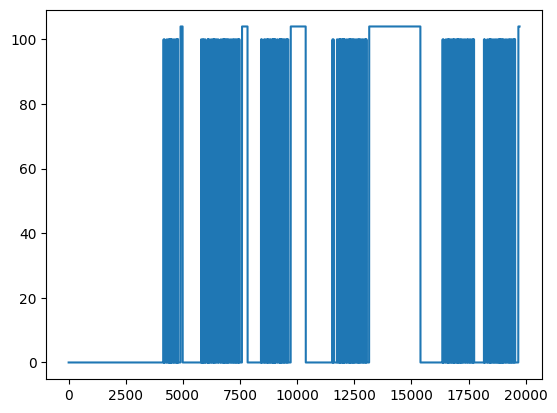

In [155]:
plt.plot(df_qualifying_car_data["brake"])

Widzimy pojedyńcze okrążenie, a następnie okres z wartością 104, postaramy się po prostu omijać te okresy, zresztą powinno przyjść nam to naturalnie przy wybieraniu czasów okrążeń (zaraz będzie to jasne).

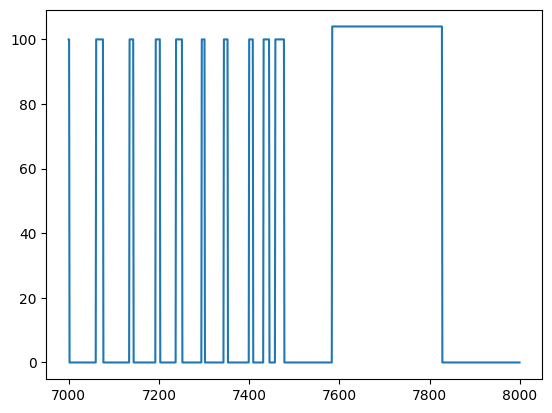

In [156]:
plt.plot(df_qualifying_car_data["brake"][7000:8000])

Teraz zajmiemy się danymi okrążeń, i spróbujemy na ich podstawie wyszczególnić w danych bolidu czas rozpoczęcia i zakończenia okrążenia. Na początek zaczniemy od sformatowania danych

In [157]:
df_qualifying_laps_data = pd.DataFrame(qualifying_laps_data)

df_qualifying_laps_data["date_start"] = pd.to_datetime(df_qualifying_laps_data["date_start"], format='ISO8601')

df_qualifying_laps_data["lap_duration"] = pd.to_timedelta(df_qualifying_laps_data["lap_duration"], unit="s")

Widzimy, iż kolumna is_pit_out_lap wskazuje, iż dwa pierwsze zarejestrowane okrążenia były przygotowujące, więc nie będziemy ich brać pod uwagę i zajmiemy się 3 okrążeniem, które jest tym właściwym 

In [158]:
df_qualifying_laps_data

,meeting_key,session_key,driver_number,i1_speed,i2_speed,st_speed,date_start,lap_duration,is_pit_out_lap,duration_sector_1,duration_sector_2,duration_sector_3,segments_sector_1,segments_sector_2,segments_sector_3,lap_number
0,1141,7768,1,204,NaN,178,2023-03-04 15:04:00.839000+00:00,NaT,True,NaN,NaN,NaN,"[2064, 2064, 2064, 2049, 2049, 2049, 2049, 204...","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2048, 2048, 2048, 2049, 2049, 2049, 0]",1
1,1141,7768,1,219,217.0,141,2023-03-04 15:12:21.455000+00:00,NaT,True,NaN,53.666,38.509,"[None, 2064, 2064, 2048, 2048, 2049, 2049, 204...","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2049, 2049, 2049, 2049, 2049, 2048, 0]",2
2,1141,7768,1,240,270.0,322,2023-03-04 15:14:33.390000+00:00,0 days 00:01:31.295000,False,29.152,39.195,22.948,"[2049, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2051, 2049, 2049, 2049, 2049, 2051, 2049, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2064]",3
3,1141,7768,1,205,215.0,234,2023-03-04 15:16:04.919000+00:00,0 days 00:01:49.812000,False,35.615,44.953,29.244,"[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 0]",4
4,1141,7768,1,170,155.0,142,2023-03-04 15:22:49.521000+00:00,0 days 00:07:12.160000,True,333.663,53.390,45.107,"[2064, 2064, 2064, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[0, 0, 0, 0, 0, 0, 0]",5
5,1141,7768,1,195,185.0,135,2023-03-04 15:25:06.706000+00:00,0 days 00:02:12.516000,False,48.978,48.136,35.402,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2049, 2049, 2049, 2049, 2051, 2049]",6
6,1141,7768,1,182,172.0,171,2023-03-04 15:36:40.788000+00:00,0 days 00:11:26.562000,True,599.070,56.693,30.799,"[2064, 2064, 2064, 2049, 2049, 2049, 2049, 204...","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2051, 2049, 2049, 2049, 2051, 2048, 0]",7
7,1141,7768,1,240,270.0,323,2023-03-04 15:38:45.707000+00:00,0 days 00:01:30.503000,False,28.925,38.915,22.663,"[2049, 2049, 2049, 2049, 2049, 2051, 2049, 204...","[2049, 2049, 2049, 2049, 2051, 2051, 2049, 204...","[0, 0, 0, 0, 0, 0, 0]",8
8,1141,7768,1,158,184.0,204,2023-03-04 15:40:16.268000+00:00,0 days 00:02:05.756000,False,38.904,53.517,33.335,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2051, 2049, 2049, 2049, 2049, 2051]",9
9,1141,7768,1,188,196.0,168,2023-03-04 15:57:27.484000+00:00,0 days 00:17:00.315000,True,939.877,52.962,27.476,"[2064, 2064, 2064, 2049, 2049, 2051, 2051, 205...","[2051, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2051, 2049, 2049, 2049, 2049, 2048, 2048]",10


W ten sposób uzyskujemy czas rozpoczęcia okrążenia kwalifikacyjnego

In [159]:
df_qualifying_laps_data["date_start"][2]

Timestamp('2023-03-04 15:14:33.390000+0000', tz='UTC')

W celu znalezienia timestampu, tworzymy funkcję, która na podstawie najmniejszej absolutnej różnicy, wybiera dla nas index wiersza z qualifying_car_data

In [160]:
lap1start_time = df_qualifying_laps_data["date_start"][2]

def data_closest_timestamp(time, data):
    
    minimal_diff = np.abs(time - data["date"][0])
    minimal_index = 0
    
    for index, value in data['date'].items():
        diff = np.abs(time - value)
        if minimal_diff > diff:
            minimal_diff = diff
            minimal_index = index
        
    return minimal_index


Otrzymujemy index okrążenia startowego, możemy dla pewności sprawdzić czas

In [161]:
qualifying_start_lap_index = data_closest_timestamp(lap1start_time, df_qualifying_car_data)

qualifying_start_lap_index

6689

In [162]:
df_qualifying_car_data["date"][qualifying_start_lap_index]

Timestamp('2023-03-04 15:14:33.486000+0000', tz='UTC')

Nie jest to idealny wybór, musimy zaakceptować stratę (a bardziej korektę czasów) 0.096s, na razie nie będziemy tego korygować

In [163]:
df_qualifying_car_data["date"][qualifying_start_lap_index] - df_qualifying_laps_data["date_start"][2]

Timedelta('0 days 00:00:00.096000')

Teraz chcemy znaleźć index zakońćzenia, w tym celu dodamy do czasu startu czas okrążenia pobrany z tabeli df_qualifying_laps_data i postąpimy analogicznie jak w przypadku poszukiwania indexu startowego

In [164]:
df_qualifying_laps_data["lap_duration"][2]

Timedelta('0 days 00:01:31.295000')

In [165]:
qualifying_end_lap_index = data_closest_timestamp(lap1start_time + df_qualifying_laps_data["lap_duration"][2], df_qualifying_car_data)

qualifying_end_lap_index

7033

Konwertujemy czas na względny od rozpoczęcia okrążenia, tak aby wyświetlać czas w sekunach a nie godziny zegarowe w których odbywało się okrążenie, nie miałoby to większego sensu

In [166]:
start_time = df_qualifying_car_data["date"][qualifying_start_lap_index]
df_qualifying_time = df_qualifying_car_data["date"][qualifying_start_lap_index:qualifying_end_lap_index].apply(lambda x: (x - start_time).total_seconds())

df_qualifying_time

6689     0.00
6690     0.28
6691     0.56
6692     0.76
6693     1.08
        ...  
7028    89.84
7029    90.08
7030    90.28
7031    90.60
7032    90.80
Name: date, Length: 344, dtype: float64

W ten sposób docieramy do pierwszych wykresów, na których widać kolejno czas, brake i throttle w zależności od czasu okrążenia

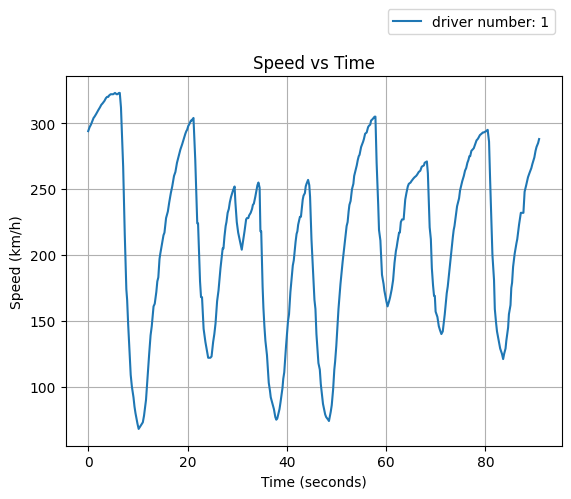

In [167]:
plt.plot(df_qualifying_time,  df_qualifying_car_data["speed"][qualifying_start_lap_index:qualifying_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs Time")
plt.grid(True)
plt.show()

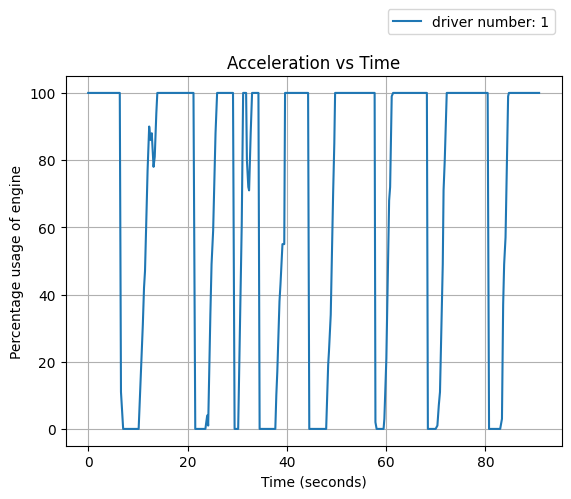

In [168]:
plt.plot(df_qualifying_time,  df_qualifying_car_data["throttle"][qualifying_start_lap_index:qualifying_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Percentage usage of engine")
plt.title("Acceleration vs Time")
plt.grid(True)
plt.show()

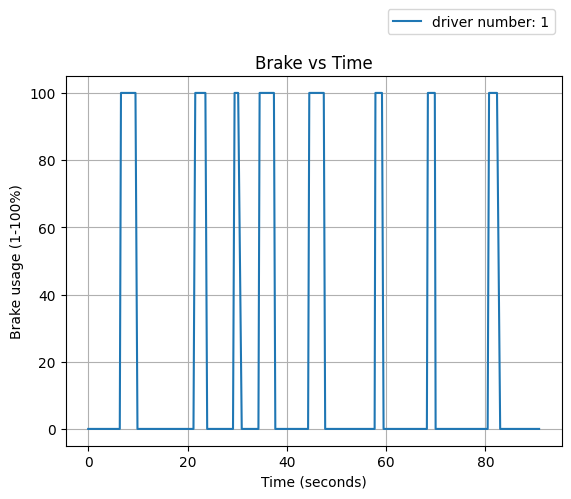

In [169]:
plt.plot(df_qualifying_time,  df_qualifying_car_data["brake"][qualifying_start_lap_index:qualifying_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Brake usage (1-100%)")
plt.title("Brake vs Time")
plt.grid(True)
plt.show()

(nieoficnjalna część analizy)
dalsza analiza:

    analiza różnicowa:
    
        - samo wyznaczenie pochodnej:
        
            - metody numeryczne jako przybliżenie pochodnej
            
            - wyznaczenie funkcji poprzez regresje wielomianowa (raczej usless, poewnie mało dokładne + obliczeniowo cieższe i guess)
            
            - interpolacja wielomianowa
    
        - badanie względnego tempa zmiany funkcji, użycie pochodnej logarytmicznej (nie wiem po co, chat zaproponował)

    Analiza trajektorii i dynamiki pojazdu:
    
        - to co podesłał maciek, ziomek tam też estymuje pochodna, tez metody numeryczne ale jeszcze jakies inne rzeczy
        http://www.holoborodko.com/pavel/numerical-methods/numerical-derivative/smooth-low-noise-differentiators/ 

        podciagu tu jeszcze jakąś redukcje szumów itd, ale ogólnie to + połączenie z tym identycznej analizy ale brake/throttle dałoby nam może jakiś benchmark do określenia czy kierowca zasuwa czy nie, albo np żeby nie było 0/1 to zawrzeć w przedziale procentowym (chociaz idk jak wtedy określac kwalifikacje, 100%?)

        np. takie "Przyspieszenie poprzeczne (lat_acc) – siła odśrodkowa wynikająca z krzywizny toru, czyli a_y = v^2 * k

        ale ogolnie sama idea aproksymacji pochodnych i porownania -> liczenia jak dynamicznie sie co zmienia seems the way 
        
    Metody klasyfikacji i analiza klastrów:
        - idk nie znam nic poza pca i k-means


Stworzenie funkcji aproksymującej pochodną wykresu (throttle, brake, speed, etc), dzięki czemu badać będzie można dynamikę wykresu i go porównywać (still in progress)

In [170]:
import math
def smooth_derivative(t_in,v_in, method="centered"):

    #
    # Function to compute a smooth estimation of a derivative.
    # [REF: http://holoborodko.com/pavel/numerical-methods/numerical-derivative/smooth-low-noise-differentiators/]
    #
    
    # Configuration
    #
    # Derivative method: two options: 'smooth' or 'centered'. Smooth is more conservative
    # but helps to supress the very noisy signals. 'centered' is more agressive but more noisy
 
    
    t = t_in.copy()
    v = v_in.copy()

    
    # (0) Prepare inputs

    t = np.array(t)
    v = np.array(v)
    
    # (0.1) Assert they have the same size
    assert t.size == v.size
    
    # (0.2) Initialize output
    dvdt = np.zeros(t.size)
    
    # (1) Manually compute points out of the stencil
    
    dvdt[0] = (v[1]-v[0])/(t[1]-t[0])
    dvdt[1] = (v[2]-v[0])/(t[2]-t[0])
    dvdt[2] = (v[3]-v[1])/(t[3]-t[1])
    
    # (1.4) Last points
    n = t.size
    dvdt[n-1] = (v[n-1]-v[n-2])/(t[n-1]-t[n-2])
    dvdt[n-2] = (v[n-1]-v[n-3])/(t[n-1]-t[n-3])
    dvdt[n-3] = (v[n-2]-v[n-4])/(t[n-2]-t[n-4])

    # (2) Compute the rest of the points
    if (method=='smooth'):
        c = [5./32., 4./32., 1./32.]
        for i in range(3,t.size-3):
            for j in range(1,4):
                dvdt[i] += 2*j*c[j-1]*(v[i+j]-v[i-j])/(t[i+j]-t[i-j])
    elif (method == 'centered'):
        for i in range(3,t.size-2):
            for j in range(1,4):
                dvdt[i] = (v[i+1]-v[i-1])/(t[i+1]-t[i-1])
                
    return dvdt

In [171]:
def remove_acceleration_outliers(acc):
    
    acc_threshold_g = 10.0
    if (math.fabs(acc[0]) > acc_threshold_g):
        acc[0] = 0.0
        
    for i in range(1,acc.size-1):
        if ( math.fabs(acc[i]) > acc_threshold_g ):
            acc[i] = acc[i-1]
            
    if (math.fabs(acc[-1]) > acc_threshold_g ):
        acc[-1] = acc[-2]            

    return acc

In [172]:
def compute_acceleration(telemetry1):

    dx = smooth_derivative(telemetry1["date"][qualifying_start_lap_index:qualifying_end_lap_index].apply(lambda x: (x - start_time).total_seconds())  ,telemetry1["throttle"][qualifying_start_lap_index:qualifying_end_lap_index])
    return dx

No coś się liczy niby nie, zera wynikaja z tego ze jest zerowe zużycie throttle czasem

In [173]:
dx = compute_acceleration(df_qualifying_car_data)
dx.shape

(344,)

In [174]:
dx

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        , -222.5       ,
       -147.05882353,  -14.47368421,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,   28.7037037 ,   38.88888889,   36.36363636,
         42.5       ,   57.69230769,   48.4375    ,   15.        ,
         -3.84615385,  -13.33333333,  -11.66666667,   28.57142857,
         36.53846154,   15.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


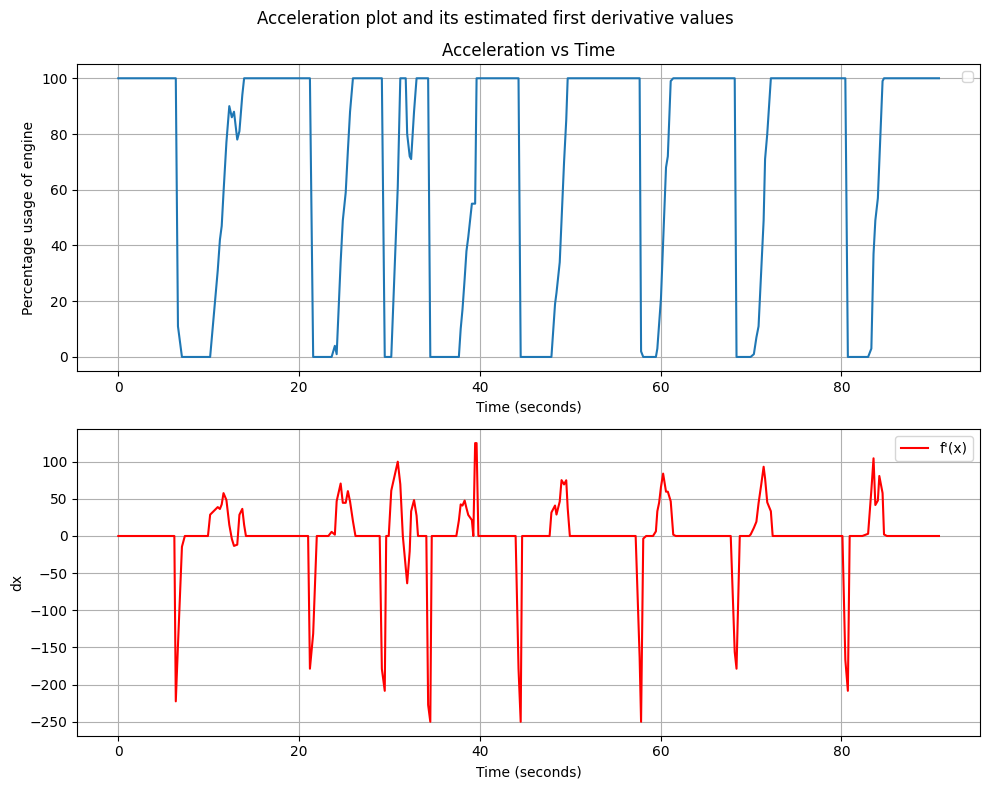

In [215]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Acceleration plot and its estimated first derivative values')

# Wykres funkcji
ax1.plot(df_qualifying_time,  df_qualifying_car_data["throttle"][qualifying_start_lap_index:qualifying_end_lap_index])
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Percentage usage of engine")
ax1.set_title("Acceleration vs Time")
ax1.legend()
ax1.grid()

# Wykres pochodnej
ax2.plot(df_qualifying_time, dx, label="f'(x)", color='r')
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("dx")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

## DANE Z WYSCIGOW

In [176]:
df_race_car_data = pd.DataFrame(race_car_data)
df_race_car_data = df_race_car_data.iloc[:, 1:-2]

df_race_car_data['date'] = pd.to_datetime(df_race_car_data['date'], format='ISO8601')

df_race_car_data['drs'] = df_race_car_data['drs'].apply(lambda x: 1 if x in [10, 12, 14] else 0)

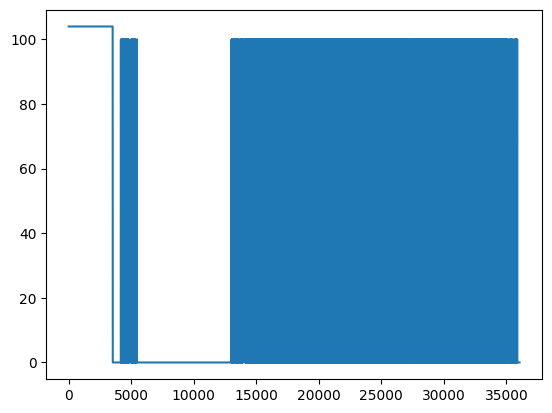

In [177]:
plt.plot(df_race_car_data["brake"])

In [178]:
df_race_laps_data = pd.DataFrame(race_laps_data)

df_race_laps_data["date_start"] = pd.to_datetime(df_race_laps_data["date_start"], format='ISO8601')

df_race_laps_data["lap_duration"] = pd.to_timedelta(df_race_laps_data["lap_duration"], unit="s")

In [179]:
df_race_laps_data

,meeting_key,session_key,driver_number,i1_speed,i2_speed,st_speed,date_start,lap_duration,is_pit_out_lap,duration_sector_1,duration_sector_2,duration_sector_3,segments_sector_1,segments_sector_2,segments_sector_3,lap_number
0,1141,7953,1,232.0,231,252.0,NaT,NaT,False,NaN,42.414,23.842,"[2048, 2048, 2049, 2049, 2051, 2051, 2049, 204...","[2051, 2049, 2051, 2049, 2051, 2049, 2049, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 0]",1
1,1141,7953,1,227.0,238,288.0,2023-03-05 15:05:17.858000+00:00,0 days 00:01:37.974000,False,31.342,42.504,24.128,"[2049, 2049, 2049, 2049, 2051, 2049, 2049, 204...","[2048, 2049, 2048, 2049, 2048, 2049, 2049, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048]",2
2,1141,7953,1,NaN,238,287.0,2023-03-05 15:06:55.793000+00:00,0 days 00:01:38.006000,False,31.388,42.469,24.149,"[None, 2049, 2048, 2048, 2048, 2049, 2049, 204...","[2048, 2051, 2048, 2048, 2048, 2049, 2049, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2048]",3
3,1141,7953,1,228.0,238,289.0,2023-03-05 15:08:33.885000+00:00,0 days 00:01:37.976000,False,31.271,42.642,24.063,"[None, 2049, 2049, 2049, 2051, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2048]",4
4,1141,7953,1,NaN,239,290.0,2023-03-05 15:10:11.852000+00:00,0 days 00:01:38.035000,False,31.244,42.724,24.067,"[None, 2049, 2049, 2048, 2051, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2049]",5
5,1141,7953,1,229.0,239,291.0,2023-03-05 15:11:49.866000+00:00,0 days 00:01:37.986000,False,31.341,42.632,24.013,"[None, 2049, 2049, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2049, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 0]",6
6,1141,7953,1,230.0,239,293.0,2023-03-05 15:13:27.880000+00:00,0 days 00:01:38.021000,False,31.290,42.763,23.968,"[None, 2049, 2049, 2049, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2049, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2049]",7
7,1141,7953,1,NaN,240,NaN,2023-03-05 15:15:05.878000+00:00,0 days 00:01:38.154000,False,31.291,42.833,24.030,"[None, 2049, 2049, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 0]",8
8,1141,7953,1,229.0,242,NaN,2023-03-05 15:16:44.033000+00:00,0 days 00:01:38.278000,False,31.336,42.823,24.119,"[None, 2049, 2049, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2048]",9
9,1141,7953,1,230.0,242,NaN,2023-03-05 15:18:22.359000+00:00,0 days 00:01:38.369000,False,31.361,42.884,24.124,"[2048, 2049, 2049, 2048, 2048, 2048, 2048, 204...","[2048, 2048, 2048, 2048, 2048, 2048, 2049, 204...","[2048, 2048, 2048, 2049, 2048, 2048, 2048]",10


In [180]:
df_race_laps_data["date_start"][1]

Timestamp('2023-03-05 15:05:17.858000+0000', tz='UTC')

In [181]:
lap1start_time = df_race_laps_data["date_start"][1]

race_start_lap_index = data_closest_timestamp(lap1start_time, df_race_car_data)

race_end_lap_index = data_closest_timestamp(lap1start_time + df_race_laps_data["lap_duration"][1], df_race_car_data)

start_time = df_race_car_data["date"][race_start_lap_index]
df_race_time = df_race_car_data["date"][race_start_lap_index:race_end_lap_index].apply(lambda x: (x - start_time).total_seconds())

df_race_time

14449     0.00
14450     0.28
14451     0.56
14452     0.88
14453     1.12
         ...  
14808    96.96
14809    97.12
14810    97.36
14811    97.56
14812    97.76
Name: date, Length: 364, dtype: float64

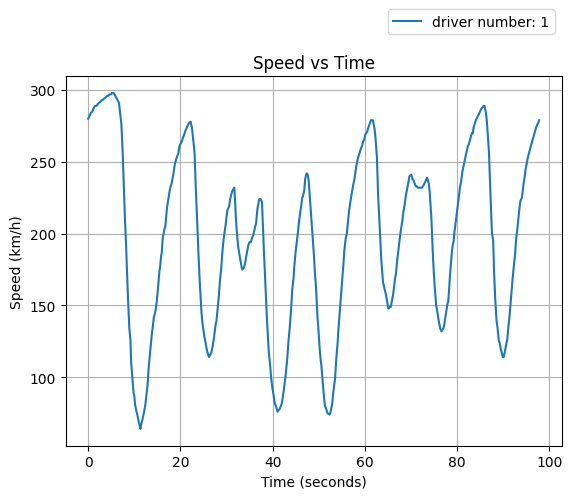

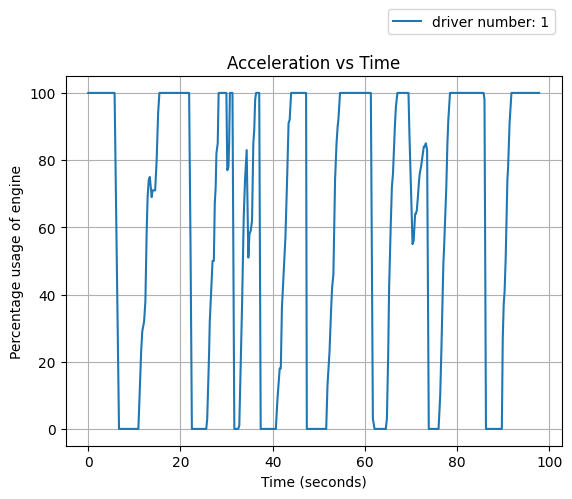

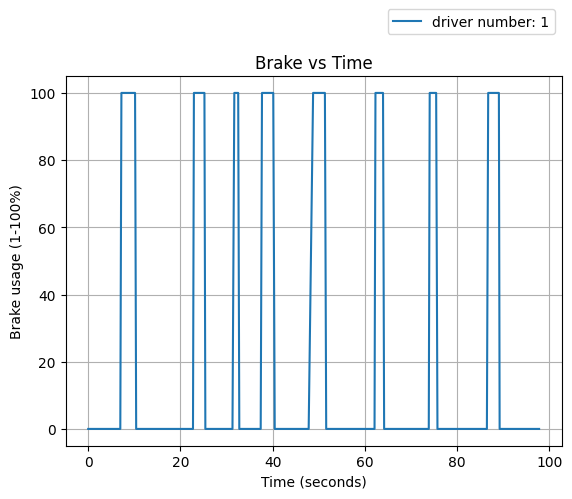

In [182]:
plt.plot(df_race_time,  df_race_car_data["speed"][race_start_lap_index:race_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs Time")
plt.grid(True)
plt.show()

plt.plot(df_race_time,  df_race_car_data["throttle"][race_start_lap_index:race_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Percentage usage of engine")
plt.title("Acceleration vs Time")
plt.grid(True)
plt.show()

plt.plot(df_race_time,  df_race_car_data["brake"][race_start_lap_index:race_end_lap_index])

plt.legend([f"driver number: {driver_number}"], bbox_to_anchor=(1.0, 1.20), ncol=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Brake usage (1-100%)")
plt.title("Brake vs Time")
plt.grid(True)
plt.show()

# PORÓWNANIE - WYŚCIG VS KWALIFIKACJE

In [206]:
diff = df_race_time.shape[0] - df_qualifying_time.shape[0]
adjusted_df_race_time = df_race_time.iloc[:df_race_time.shape[0] - diff]
adjusted_race_end_lap_index = race_end_lap_index - diff

In [199]:
adjusted_race_end_lap_index

14793

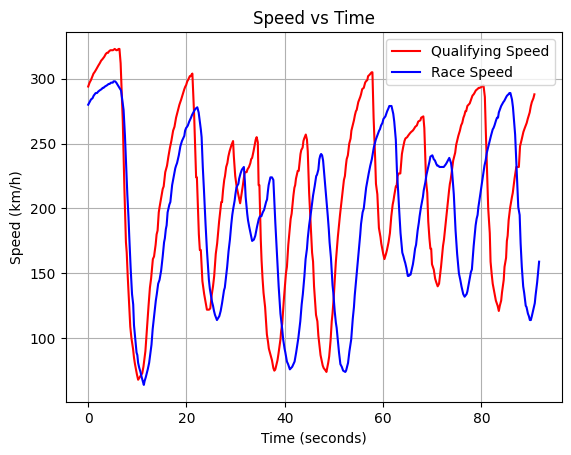

In [210]:
plt.plot(df_qualifying_time,  
         df_qualifying_car_data["speed"][qualifying_start_lap_index:qualifying_end_lap_index], 
         c='r', label="Qualifying Speed")

plt.plot(adjusted_df_race_time,  
         df_race_car_data["speed"][race_start_lap_index:adjusted_race_end_lap_index], 
         c='b', label="Race Speed")

plt.xlabel("Time (seconds)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs Time")
plt.legend()
plt.grid(True)
plt.show()

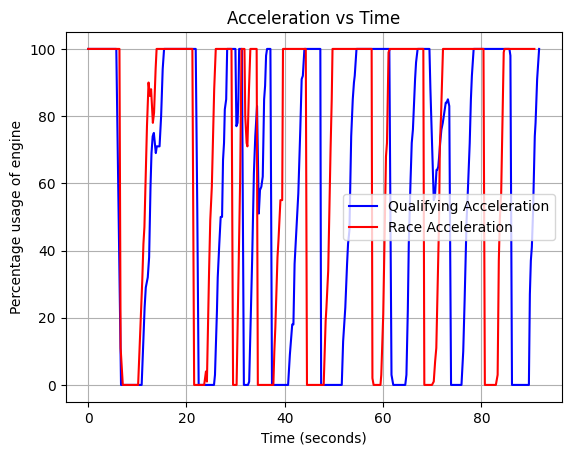

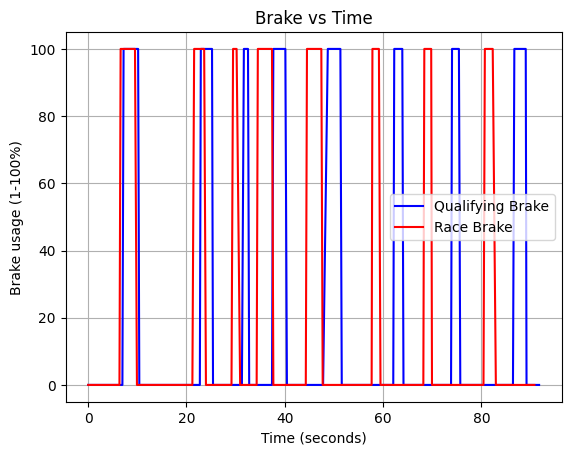

In [213]:
plt.plot(adjusted_df_race_time,  df_race_car_data["throttle"][race_start_lap_index:adjusted_race_end_lap_index], c='b', label="Qualifying Acceleration")
plt.plot(df_qualifying_time,  df_qualifying_car_data["throttle"][qualifying_start_lap_index:qualifying_end_lap_index], c='r', label="Race Acceleration")


plt.xlabel("Time (seconds)")
plt.ylabel("Percentage usage of engine")
plt.title("Acceleration vs Time")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(adjusted_df_race_time,  df_race_car_data["brake"][race_start_lap_index:adjusted_race_end_lap_index], c='b', label="Qualifying Brake")
plt.plot(df_qualifying_time,  df_qualifying_car_data["brake"][qualifying_start_lap_index:qualifying_end_lap_index], c='r', label="Race Brake")


plt.xlabel("Time (seconds)")
plt.ylabel("Brake usage (1-100%)")
plt.title("Brake vs Time")
plt.legend()
plt.grid(True)
plt.show()

(TODO) tu bedzie wykres dwoch estymowanych pochodnych

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Acceleration plot and its derivative')

# Wykres funkcji
ax1.plot(df_time,  df_qualifying_car_data["throttle"][start_lap_index:end_lap_index])
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Percentage usage of engine")
ax1.set_title("Acceleration vs Time")
ax1.legend()
ax1.grid()

# Wykres pochodnej
ax2.plot(df_time, dx, label="f'(x)", color='r')
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("dx")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()